### Introduction

When an employee at any company starts work, they first need to obtain the computer access necessary to fulfill their role. This access may allow an employee to read/manipulate resources through various applications or web portals. It is assumed that employees fulfilling the functions of a given role will access the same or similar resources. It is often the case that employees figure out the access they need as they encounter roadblocks during their daily work (e.g. not able to log into a reporting portal). A knowledgeable supervisor then takes time to manually grant the needed access in order to overcome access obstacles. As employees move throughout a company, this access discovery/recovery cycle wastes a nontrivial amount of time and money.

There is a considerable amount of data regarding an employee’s role within an organization and the resources to which they have access. Given the data related to current employees and their provisioned access, models can be built that automatically determine access privileges as employees enter and leave roles within a company. These auto-access models seek to minimize the human involvement required to grant or revoke employee access.

### Objective

The objective of this competition is to build a model that will learn using historical data, that will determine an employee’s access needs, such that manual access transactions (grants and revokes) are minimized as the employee’s attributes change over time. The model will take an employee’s role information and a resource code and will return whether or not access should be granted.

### Script

#### imports

In [3]:
from pyforest import *
lazy_imports()

['from sklearn.model_selection import RandomizedSearchCV',
 'from dask import dataframe as dd',
 'from fbprophet import Prophet',
 'import sklearn',
 'import skimage',
 'import matplotlib.pyplot as plt',
 'import os',
 'import plotly.express as px',
 'import matplotlib as mpl',
 'import awswrangler as wr',
 'from sklearn.feature_extraction.text import CountVectorizer',
 'from sklearn.decomposition import PCA',
 'import pydot',
 'from pyspark import SparkContext',
 'from sklearn.ensemble import RandomForestRegressor',
 'from sklearn.preprocessing import MinMaxScaler',
 'import spacy',
 'from sklearn.preprocessing import StandardScaler',
 'import numpy as np',
 'import bokeh',
 'from sklearn.preprocessing import OneHotEncoder',
 'import tqdm',
 'import pandas as pd',
 'from sklearn.ensemble import GradientBoostingClassifier',
 'from sklearn.cluster import KMeans',
 'from sklearn.model_selection import train_test_split',
 'import cv2',
 'import keras',
 'from sklearn.linear_model import L

In [4]:
import warnings
warnings.filterwarnings('ignore')

#### Read Csv

In [5]:
train_df = pd.read_csv('dataset/amazontrain.csv',header = 0)
train_df.head()

<IPython.core.display.Javascript object>

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


#### About Data


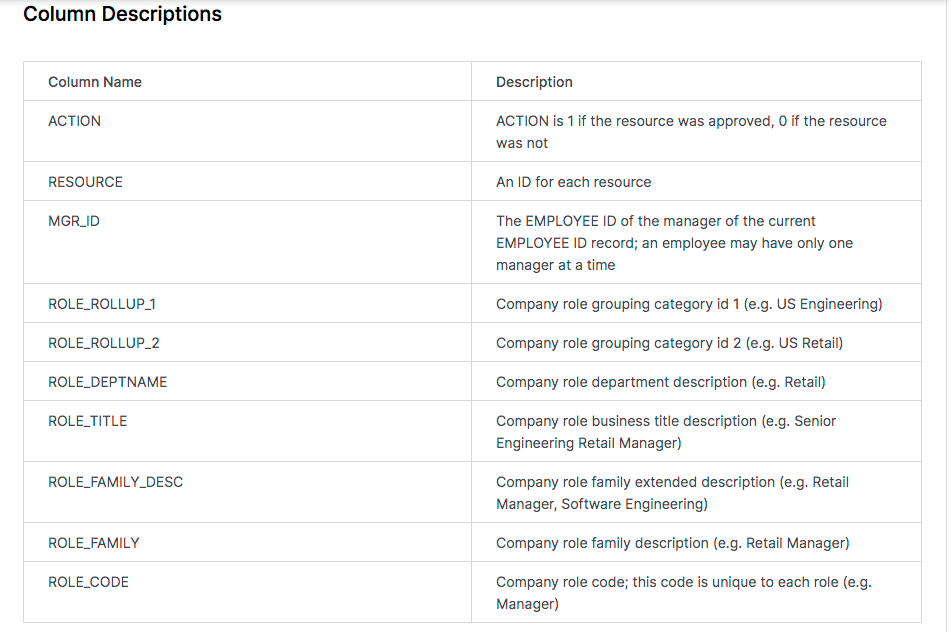

#### EDA

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


Here the data is quite cleaned and processed into numerical for better operations.But still those are categories ,we need to encode it or run catboost to handle the categories.

In [7]:
# unique category

train_df.apply(lambda x :len(x.unique()))

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

##### describe

In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ACTION,32769.0,0.942110,0.233539,0.0,1.0,1.0,1.0,1.0
RESOURCE,32769.0,42923.916171,34173.892702,0.0,20299.0,35376.0,74189.0,312153.0
MGR_ID,32769.0,25988.957979,35928.031650,25.0,4566.0,13545.0,42034.0,311696.0
ROLE_ROLLUP_1,32769.0,116952.627788,10875.563591,4292.0,117961.0,117961.0,117961.0,311178.0
ROLE_ROLLUP_2,32769.0,118301.823156,4551.588572,23779.0,118102.0,118300.0,118386.0,286791.0
ROLE_DEPTNAME,32769.0,118912.779914,18961.322917,4674.0,118395.0,118921.0,120535.0,286792.0
ROLE_TITLE,32769.0,125916.152644,31036.465825,117879.0,118274.0,118568.0,120006.0,311867.0
ROLE_FAMILY_DESC,32769.0,170178.369648,69509.462130,4673.0,117906.0,128696.0,235280.0,311867.0
ROLE_FAMILY,32769.0,183703.408893,100488.407413,3130.0,118363.0,119006.0,290919.0,308574.0
ROLE_CODE,32769.0,119789.430132,5784.275516,117880.0,118232.0,118570.0,119348.0,270691.0


##### Column Plots

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

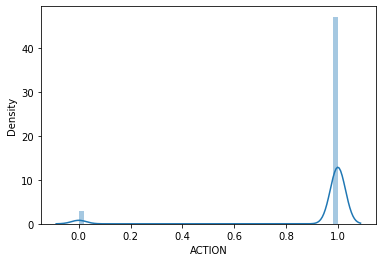

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

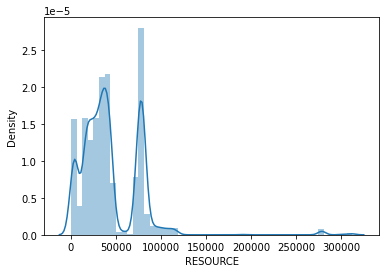

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

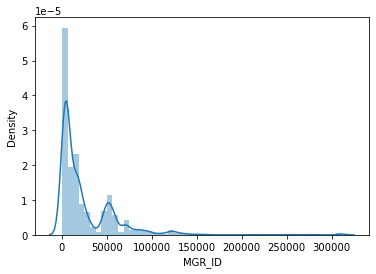

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

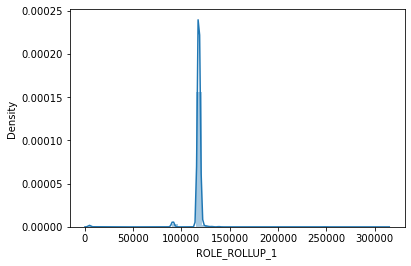

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

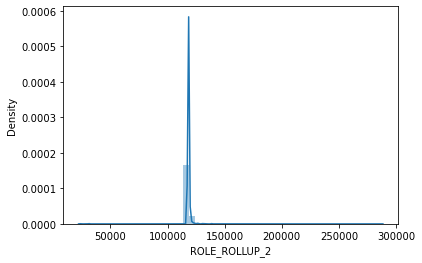

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

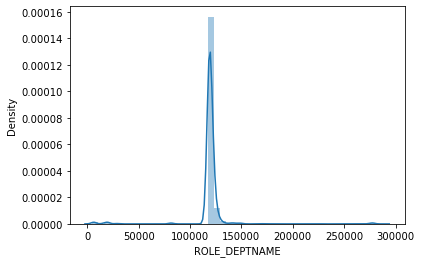

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

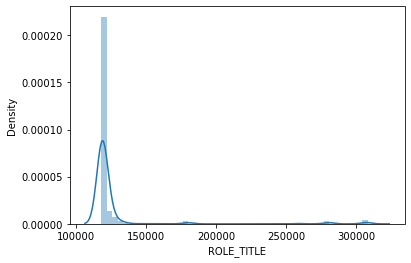

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

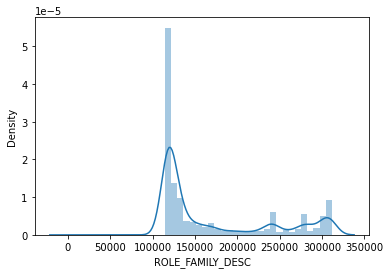

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

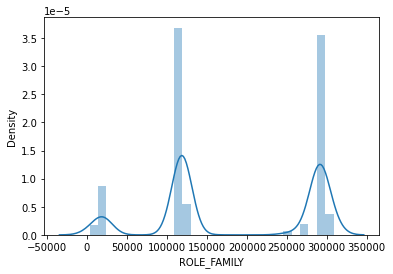

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

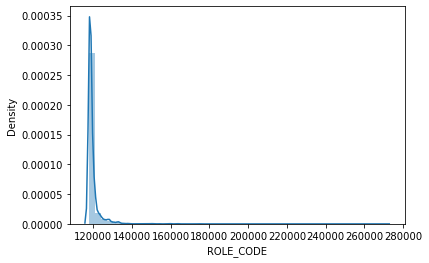

In [9]:
for i in train_df.columns:
    sns.distplot(train_df[i].dropna())
    plt.show()

#### Data Balance Check

In [10]:
train_df.ACTION.value_counts()

1    30872
0     1897
Name: ACTION, dtype: int64

Here the data is clearly imbalance

##### Box Plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

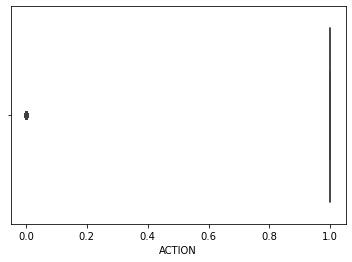

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

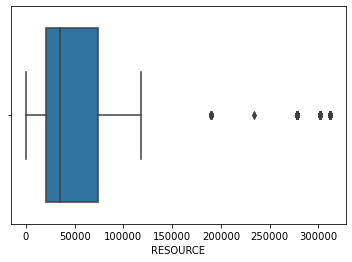

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

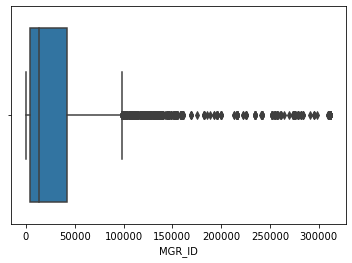

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

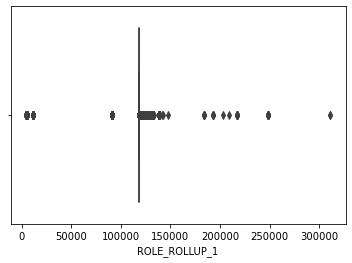

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

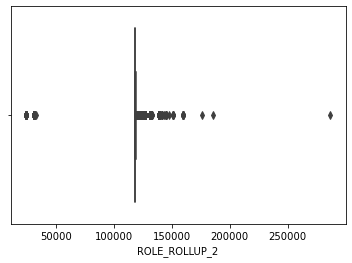

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

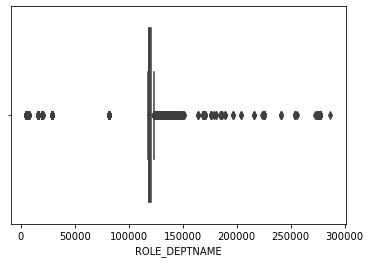

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

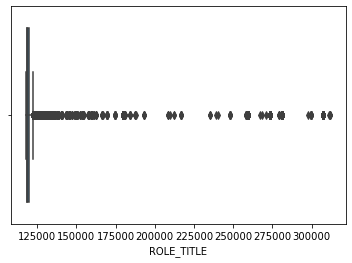

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

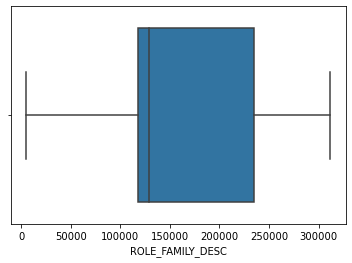

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

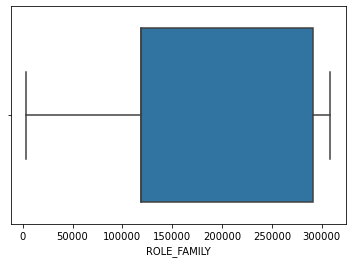

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

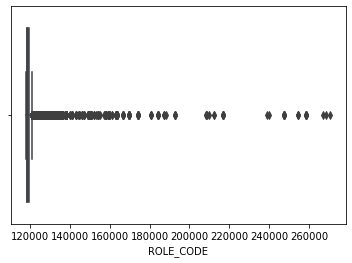

In [11]:
for i in train_df.columns:
    sns.boxplot(train_df[i].dropna())
    plt.show()

##### Heat map Correlation

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

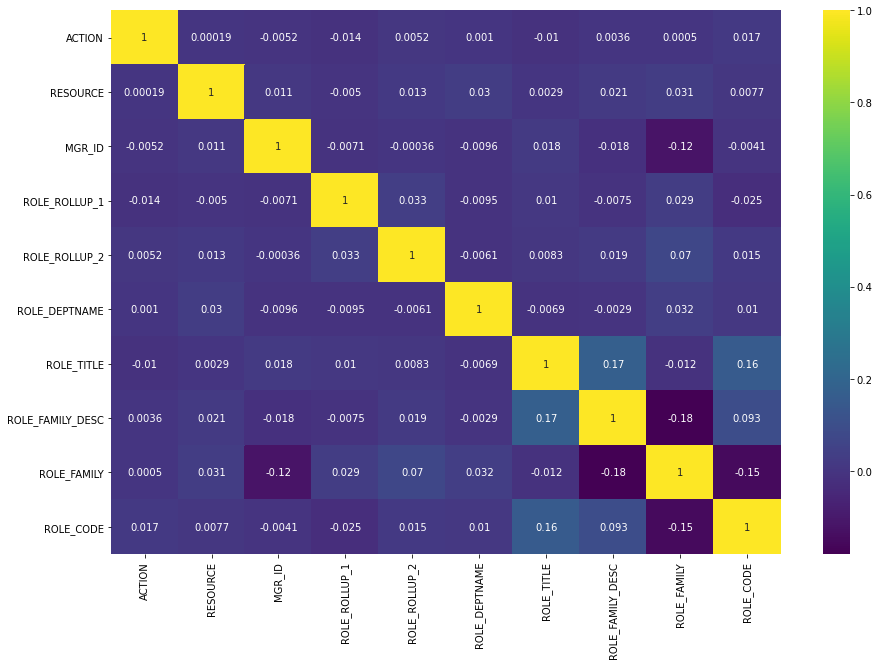

In [12]:
plt.figure(figsize = (15,10))
sns.heatmap(train_df.corr(),cmap = 'viridis',annot = True)

#### Model Building

##### test train split 

In [13]:
X = train_df.drop(['ACTION'],axis = 1)
y = train_df['ACTION']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 13)

<IPython.core.display.Javascript object>

##### Catboost

CatBoost is a high-performance open source library for gradient boosting on decision trees

*  Great quality without parameter tuning :
Reduce time spent on parameter tuning, because CatBoost provides great results with default parameters

*  Categorical features support :
Improve your training results with CatBoost that allows you to use non-numeric factors, instead of having to pre-process your data or spend time and effort turning it to numbers.

*  Fast and scalable GPU version :
Train your model on a fast implementation of gradient-boosting algorithm for GPU. Use a multi-card configuration for large datasets.

*  Improved accuracy :
Reduce overfitting when constructing your models with a novel gradient-boosting scheme.

*  Fast prediction :
Apply your trained model quickly and efficiently even to latency-critical tasks using CatBoost's model applier

CatBoost is an algorithm for gradient boosting on decision trees. It is developed by Yandex researchers and engineers, and is used for search, recommendation systems, personal assistant, self-driving cars, weather prediction and many other tasks at Yandex and in other companies, including CERN, Cloudflare, Careem taxi. It is in open-source and can be used by anyone.



In [16]:
from catboost import CatBoostClassifier

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features':[0,1,2,3,4,5,6,7,8],#here all our ccolumns are categories hence need to be handled or encoded
          'verbose':200,
          'random_seed':13}

catmodel_1 = CatBoostClassifier(**params).fit(X_train,y_train,eval_set = (X_test,y_test),use_best_model = True)

Learning rate set to 0.071005
0:	test: 0.5661582	best: 0.5661582 (0)	total: 29.1ms	remaining: 29.1s
200:	test: 0.8679332	best: 0.8680000 (185)	total: 9.02s	remaining: 35.8s
400:	test: 0.8725498	best: 0.8725498 (400)	total: 19s	remaining: 28.4s
600:	test: 0.8752570	best: 0.8752570 (600)	total: 28.8s	remaining: 19.1s
800:	test: 0.8767664	best: 0.8774436 (748)	total: 38.2s	remaining: 9.5s
999:	test: 0.8761652	best: 0.8774436 (748)	total: 47.2s	remaining: 0us

bestTest = 0.8774436187
bestIteration = 748

Shrink model to first 749 iterations.


##### feature importance

In [17]:
catmodel_1.get_feature_importance(prettified = True)

,Feature Id,Importances
0,RESOURCE,19.005293
1,ROLE_DEPTNAME,17.183268
2,MGR_ID,15.593876
3,ROLE_ROLLUP_2,11.050090
4,ROLE_FAMILY_DESC,10.015567
5,ROLE_CODE,7.783340
6,ROLE_TITLE,6.912280
7,ROLE_FAMILY,6.543913
8,ROLE_ROLLUP_1,5.912373


##### Catboost Cross Validation

In [21]:
from catboost import cv,Pool

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose':200,
          'random_seed':13}

cv_data = Pool(data = X,label = y,cat_features = range(0,9))

cv_score = cv(pool = cv_data, params = params, shuffle = True, fold_count = 5, stratified = True, seed = 13)


0:	test: 0.5938127	best: 0.5938127 (0)
200:	test: 0.8874598	best: 0.8874598 (200)	total: 1m 1s	remaining: 4m 4s
400:	test: 0.8913756	best: 0.8913756 (400)
600:	test: 0.8931285	best: 0.8931573 (595)	total: 3m 17s	remaining: 2m 11s
800:	test: 0.8945077	best: 0.8945077 (800)
999:	test: 0.8949021	best: 0.8949129 (983)	total: 5m 29s	remaining: 0us


##### feature Importance graph

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Feature Importance')

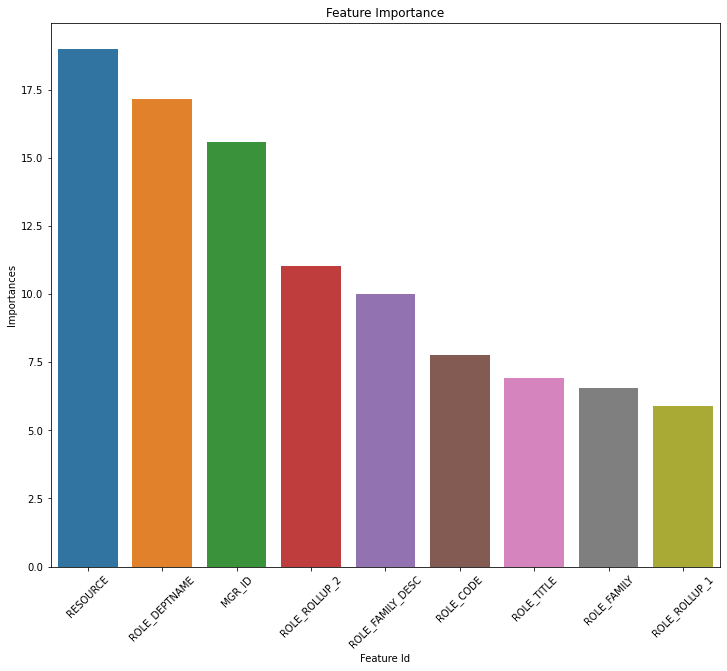

In [30]:
feature_imp = catmodel_1.get_feature_importance(prettified = True)

plt.figure(figsize = (12,10))
sns.barplot(data = feature_imp, x = 'Feature Id', y = 'Importances')
plt.xticks(rotation = 45)
plt.title('Feature Importance')

##### Evaluation

In [31]:
catmodel_1.score(X_test,y_test)

0.954684162343607

In [35]:
metrics.confusion_matrix(y_test,catmodel_1.predict(X_test))

<IPython.core.display.Javascript object>

array([[ 142,  221],
       [  76, 6115]], dtype=int64)

In [38]:
metrics.precision_score(y_test,catmodel_1.predict(X_test))

<IPython.core.display.Javascript object>

0.9651199494949495

In [39]:
metrics.recall_score(y_test,catmodel_1.predict(X_test))

<IPython.core.display.Javascript object>

0.9877241156517526

In [41]:
metrics.f1_score(y_test,catmodel_1.predict(X_test))

<IPython.core.display.Javascript object>

0.976291210984274

In [45]:
print(metrics.classification_report(y_test,catmodel_1.predict(X_test)))

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.65      0.39      0.49       363
           1       0.97      0.99      0.98      6191

    accuracy                           0.95      6554
   macro avg       0.81      0.69      0.73      6554
weighted avg       0.95      0.95      0.95      6554



f1 score , recall as well as precision for 0 class is low because of data imbalance !

##### upsampling for data imbalance fix

In [46]:
access_revoked = train_df[train_df['ACTION'] == 0]
access_granted = train_df[train_df['ACTION'] == 1]

from sklearn.utils import resample

upsampled_revoked = resample(access_revoked, replace = True, n_samples = len(access_granted), random_state = 13)

upsampled_df = pd.concat([access_granted,upsampled_revoked])

upsampled_df.ACTION.value_counts()

<IPython.core.display.Javascript object>

0    30872
1    30872
Name: ACTION, dtype: int64

##### catboost using upsample data

In [47]:
X = upsampled_df.drop(['ACTION'],axis = 1)
y = upsampled_df['ACTION']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 13 )

<IPython.core.display.Javascript object>

In [48]:
from catboost import CatBoostClassifier

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features':[0,1,2,3,4,5,6,7,8],#here all our ccolumns are categories hence need to be handled or encoded
          'verbose':200,
          'random_seed':13}

catmodel_2 = CatBoostClassifier(**params).fit(X_train,y_train,eval_set = (X_test,y_test),use_best_model = True)

Learning rate set to 0.083033
0:	test: 0.9301680	best: 0.9301680 (0)	total: 57.1ms	remaining: 57.1s
200:	test: 0.9999965	best: 0.9999969 (126)	total: 12.2s	remaining: 48.6s
400:	test: 0.9999964	best: 0.9999969 (126)	total: 20.5s	remaining: 30.6s
600:	test: 0.9999964	best: 0.9999969 (126)	total: 28.4s	remaining: 18.9s
800:	test: 0.9999964	best: 0.9999969 (126)	total: 36.6s	remaining: 9.1s
999:	test: 0.9999964	best: 0.9999969 (126)	total: 44.6s	remaining: 0us

bestTest = 0.9999968518
bestIteration = 126

Shrink model to first 127 iterations.


In [49]:
catmodel_1.get_feature_importance(prettified = True)

,Feature Id,Importances
0,RESOURCE,19.005293
1,ROLE_DEPTNAME,17.183268
2,MGR_ID,15.593876
3,ROLE_ROLLUP_2,11.050090
4,ROLE_FAMILY_DESC,10.015567
5,ROLE_CODE,7.783340
6,ROLE_TITLE,6.912280
7,ROLE_FAMILY,6.543913
8,ROLE_ROLLUP_1,5.912373


##### Evaluation`

In [51]:
catmodel_2.score(X_test,y_test)

0.9993521742651227

In [52]:
metrics.confusion_matrix(y_test,catmodel_2.predict(X_test))

<IPython.core.display.Javascript object>

array([[6257,    6],
       [   2, 6084]], dtype=int64)

In [53]:
metrics.f1_score(y_test,catmodel_1.predict(X_test))

<IPython.core.display.Javascript object>

0.8342061742006617

In [54]:
print(metrics.classification_report(y_test,catmodel_1.predict(X_test)))

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.99      0.62      0.76      6263
           1       0.72      0.99      0.83      6086

    accuracy                           0.81     12349
   macro avg       0.85      0.81      0.80     12349
weighted avg       0.86      0.81      0.80     12349

